<a href="https://colab.research.google.com/github/marie-ganon/Projet-Python-S1/blob/main/Statistiques_descriptives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chargement des packages et de la base

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from urllib import request
from wordcloud import WordCloud, STOPWORDS 
import csv
import bs4
from tqdm.notebook import trange, tqdm
import seaborn as sns
import numpy as np
import zipfile
import tempfile

In [71]:
temp_dir = tempfile.mkdtemp()

with zipfile.ZipFile('base.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

df = pd.read_csv(r'temp_dir/base.csv', sep=',', low_memory = False)

FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [36]:
 df = pd.read_csv('base.csv')

Dans ce notebook, nous allons réaliser des statistiques descriptives variées sur le contenu de notre base.

#### Sommaire
1. Quelques généralités sur les variables
2. Statistiques sur la variable *genre*
3. Statistiques sur le budget
4. Statistiques sur le revenu
5. Statistique sur les mots-clés
    - Récupération de la base et premier nuage de mots
    - Apparition des mots-clés en fonction du genre
    - Score et mots-clés
6. Statistique sur le résumé
    - Détermination des mots fréquement utilisés dans les meilleurs films
        - Par LDA
        - via ACP (?)



# Quelques généralités

Avant de commencer, on peut essayer d'observer pour la base nettoyée la matrice des corrélations afin d'avoir une idée des liens entre les différentes variables.

On peut noter qu'on s'attend à ce que *score_1* soit corrélé fortement à *vote_average* et *vote_count* par construction. 

In [38]:
 corr = df.corr()
corr.style.background_gradient(cmap = 'coolwarm')

La matrice de corrélation ne nous apporte pas énormément d'information. On peut essayer de voir sur le subset complet du dataset. 

In [37]:
corr = df.dropna().corr()
corr.style.background_gradient(cmap = 'coolwarm')

# Statistiques sur la variable *genre*

On créé un data frame comportant tous les genres de films présents dans la base.

In [73]:
l = []
for i in trange(len(df)):
    genre = str(df.genres[i]).split()
    for j in genre :
        l.append(j)

      
df_genre = pd.DataFrame(l, columns=['genre'])


Text(0.5, 1.0, 'Occurrences des genres sur la base complète')

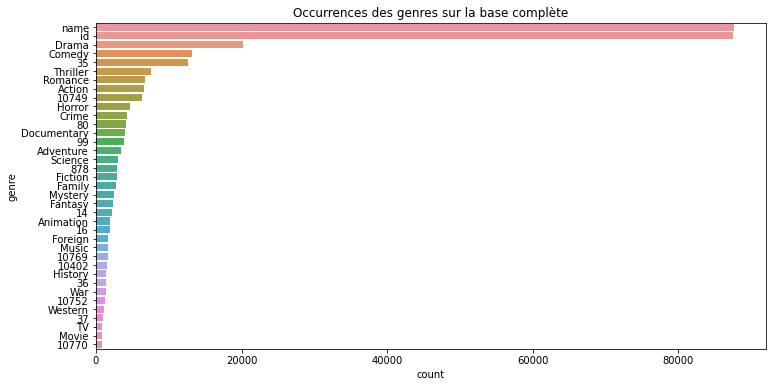

In [22]:
df_genre.genre = df_genre.genre.str.replace(r',', '')
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(y = df_genre.genre, order = df_genre['genre'].value_counts().index)
plt.title('Occurrences des genres sur la base complète')

Le graphique ci-dessus nous informe que les deux genres les plus représentés dans la base sont les comédies et les drames. Ce résultat est assez logique car ces types de films sont souvent donnés en complément d'un autre genre. A présent, étudions les films les mieux classés.

In [74]:
df.vote_count

0        5415.0
1        2413.0
2          92.0
3          34.0
4         173.0
          ...  
42975       1.0
42976      26.0
42977       1.0
42978       3.0
42979       6.0
Name: vote_count, Length: 42980, dtype: float64

En regardant de plus près la variable *vote_count*, nous constatons que certains films comportent moins de 10 évaluations. Par conséquent, afin d'avoir une analyse plus fine de la base, nous allons étudier les genres les plus représentés sur les films les mieux notés selon le classement imdb, sous contrainte que suffisamment de personnes les aient évalués (plus de 100).

On construit donc "best movies" correspondant aux films ayant été notés par plus de 100 personnes et ayant une note supérieure à 7.0 qu'on compare à l'ensemble des films ayant été notés par plus de 100 personnes. 

In [75]:
df_classement =df[df.vote_count>100].sort_values(by='vote_average', ascending = False)     # on filtre sur les films qui ont été notés au moins 100 fois
df_best_movies = df_classement[df_classement.genres != '']    # on filtre sur les films pour lesquels le genre est renseigné
df_best_movies = df_best_movies[df.vote_average >= 7.0]      # on filtre sur les "meilleurs films" ie avec un score supérieur à 7
df_best_movies.reset_index(drop = True)
print('La base contient',len(df_best_movies),'films très bien notés (>= 7.0)')

La base contient 1759 films très bien notés (>= 7.0)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [25]:
l = []
for i in trange(len(df_best_movies)):
    if type(df_best_movies.genres.iloc[i]) == str :
        bm_genre = df_best_movies.genres.iloc[i].split()
        for i in bm_genre :
            l.append(i)
print(len(l))
df_bm_genre = pd.DataFrame(l, columns=['genre'])
df_bm_genre.genre = df_bm_genre.genre.str.replace(r',', '')
df_bm_genre['best_movies']=['Best movies' for i in range(len(df_bm_genre))]

df_genre['best_movies']=['All movies' for i in range(len(df_genre))]


13275


In [26]:
df_compare_genres = df_genre.append(df_bm_genre)

df_compare_genres.head()


genre best_movies
0  Animation  All movies
1     Comedy  All movies
2     Family  All movies
3  Adventure  All movies
4    Fantasy  All movies

Text(0.5, 1.0, 'Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

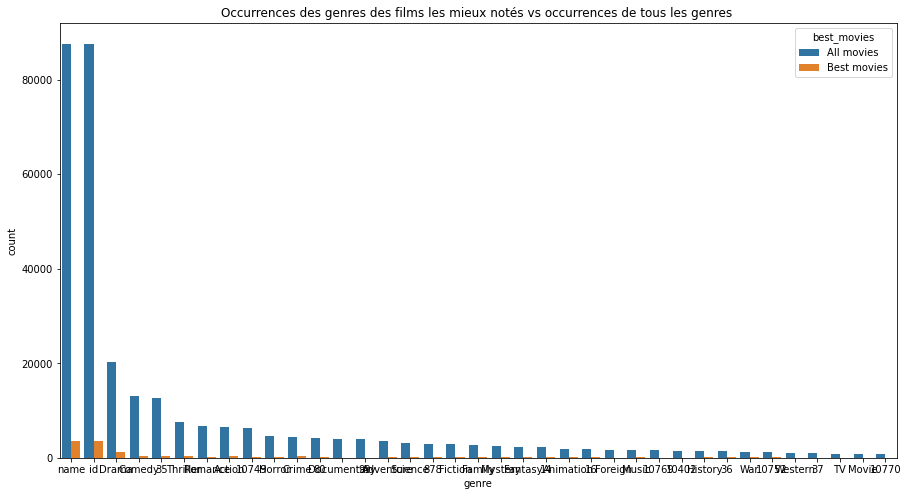

In [27]:
fig, ax = plt.subplots(figsize=(15,8))
sns.countplot(x='genre', hue='best_movies', data=df_compare_genres, order=df_genre.genre.value_counts(normalize=True).index)

plt.title('Occurrences des genres des films les mieux notés vs occurrences de tous les genres ')

Un plot des observations des genres des films les mieux notés contre ceux de tous les films ne nous permet pas de conclure. On normalise donc tout cela pour faire apparaître la fréquence d'apparition des genres pour l'ensemble des films et pour les films les mieux notés. 

Text(0.5, 1.0, 'Proportion des genres dans les films les mieux notés et dans tous les films')

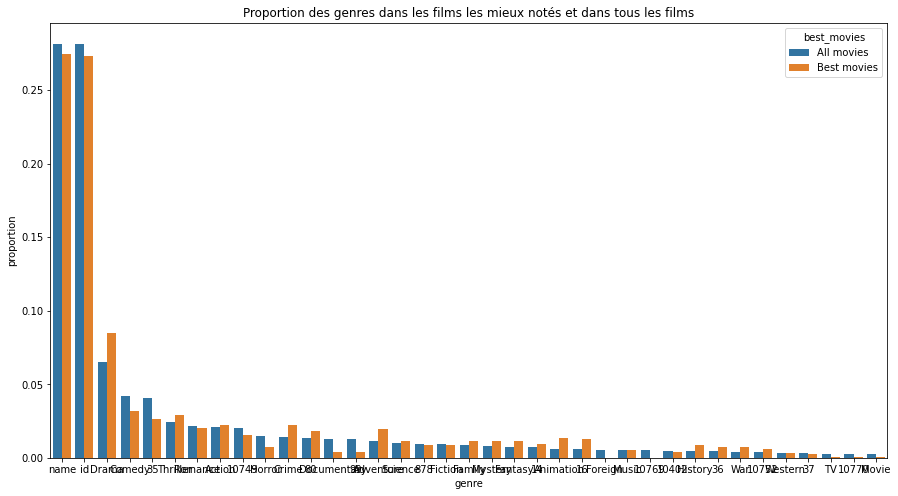

In [28]:
fig, ax = plt.subplots(figsize=(15,8))
x, y, hue = "genre", "proportion", "best_movies"
(df_compare_genres[x].groupby(df_compare_genres[hue]).value_counts(normalize=True).rename(y).reset_index().pipe((sns.barplot, "data"), x=x, y=y, hue=hue))

plt.title('Proportion des genres dans les films les mieux notés et dans tous les films')


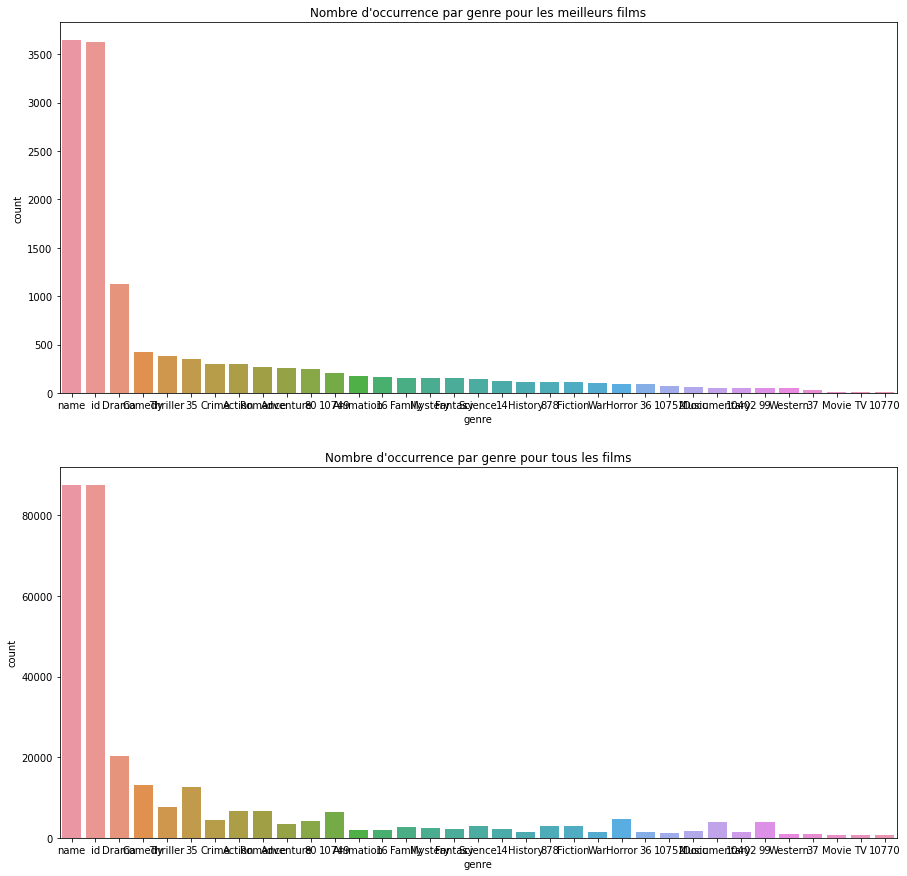

In [29]:
fig, (ax_1, ax_2) = plt.subplots(2, figsize=(15,15))
sns.countplot(x = df_bm_genre.genre, order = df_bm_genre.genre.value_counts().index, ax = ax_1)
sns.countplot(x = df_genre.genre, order = df_bm_genre.genre.value_counts().index,ax=ax_2)
ax_1.title.set_text("Nombre d'occurrence par genre pour les meilleurs films")
ax_2.title.set_text("Nombre d'occurrence par genre pour tous les films")

Nous remarquons que la tendance est sensiblement la même. En effet, avec environ plus de 18 000 films dramatiques, il est assez normal de trouver un bon nombre de films bien notés dans cet ensemble.

Toutefois, on constate que bien que certains genres de films soient très présents dans la base, ils peuvent apparaître moins souvent dans le classement des meilleurs films. 

En effet, alors que le genre Romance était le 3ème genre le plus présent, ici nous remarquons qu'il apparaît beaucoup plus loin dans le classement des genres les plus représentés dans les films les mieux notés (6e position). A l'inverse, le genre Crime est le 4 ème genre le plus représenté dans l'échantillon, et gagne alors 2 places par rapport à son classement dans l'échantillon initial.

In [236]:
df.columns

Index(['Unnamed: 0', 'budget', 'genres', 'id', 'imdb_id', 'original_language',
       'original_title', 'overview', 'popularity', 'release_date', 'revenue',
       'runtime', 'status', 'title', 'vote_average', 'vote_count',
       'collection', 'score_1', 'production_companies_name',
       'production_companies_id', 'pc_id_count', 'country_code',
       'country_name', 'imdb_rate'],
      dtype='object')

In [238]:
!pip install --upgrade plotly

     |████████████████████████████████| 13.1MB 5.2MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1


In [239]:
import plotly.express as px

In [7]:
fig = px.treemap(df, path = ['vote_average', 'popularity'])
fig.show()

ValueError: ignored

# Statistiques sur le budget

Une simple recherche internet nous informe que les budgets les plus petits dans la conception d'un film (appelés films "micro-budgets") s'élèvent à quelques milliers de dollars. On peut regarder la distribution des films micro-budgets.

In [30]:
len(df.budget[df.budget == 0])/len(df.budget)*100

79.47650069799906

In [31]:
df.budget[df.budget < 10000].describe()

count    34448.000000
mean         8.365769
std        205.607713
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       9500.000000
Name: budget, dtype: float64

Ainsi, en moyenne, les films micro-budgets (budget inférieur à 10000 dollars) ont eu 8 dollars de budget.

Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : 
 99.84904784022295 %


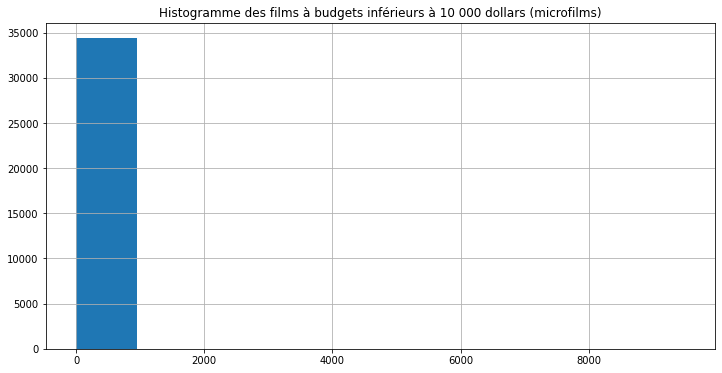

In [33]:
fig, ax = plt.subplots(figsize=(12,6))
df.budget[df.budget < 10000].hist()
plt.title('Histogramme des films à budgets inférieurs à 10 000 dollars (microfilms)')

print('Pourcentage de microfilms (budget inférieur à 10000 dollars) à budget inférieurs à 1000 dollars : \n', (len(df.budget[df.budget < 1000])/len(df.budget[df.budget < 10000]))*100,'%')

Au sein des microfilms, on compte 99.85% de films à budget inférieur à 1000 euros. Ce nombre est de fait assez suspect, on peut imaginer que la base contient des 0 pour les valeurs de budget inconnues ainsi que la plupart des nombres entre 0 et 1000 dollars de production sont des outliers dûs à des erreurs de saisies. 

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



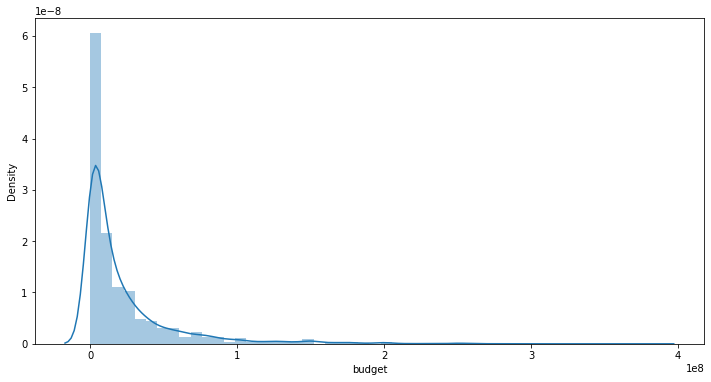

In [34]:
df_budget_ecrete = df.budget[df.budget > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_budget_ecrete)
#ax.set_xscale('log')
#ax.set_yscale('log')

((array([-3.77071513, -3.54332088, -3.41837451, ...,  3.41837451,
          3.54332088,  3.77071513]),
  array([1.04e+04, 1.10e+04, 1.10e+04, ..., 2.80e+08, 3.00e+08, 3.80e+08])),
 (27818776.291582007, 22524159.272076085, 0.8000087645208748))

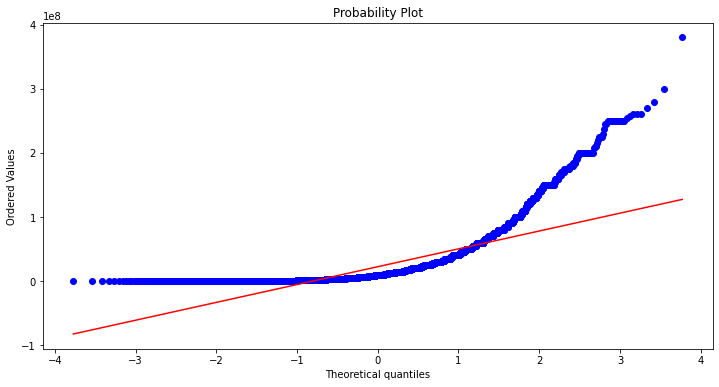

In [35]:
from scipy import stats
import seaborn as sns
fig, ax = plt.subplots(figsize=(12,6))
stats.probplot(df_budget_ecrete, plot=sns.mpl.pyplot)

L'information sur le budget paraît peu exploitable du fait de la dispersion des données... Par conséquent, nous allons nous intéresser plus en détails aux revenus générés par le film.

# Statistiques sur les revenus

Etudions tout d'abord la proportion de films n'ayant généré aucun revenu:

In [36]:
len(df.revenue[df.revenue == 0])/len(df.revenue)*100

82.83387622149837

Ainsi, plus de 83% des films de la base n'ont généré aucun revenu.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



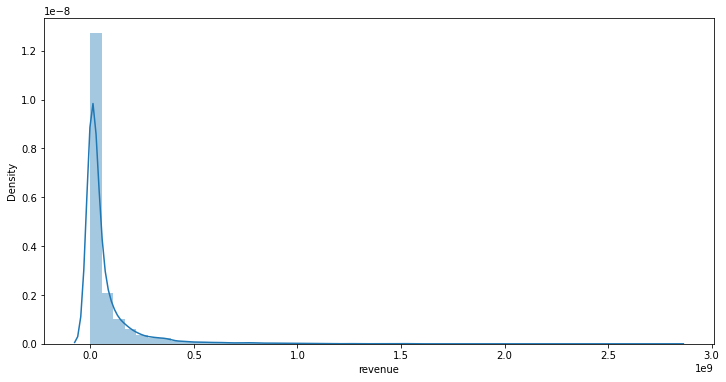

In [37]:
df_revenue_ecrete = df.revenue[df.revenue > 10000]
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(df_revenue_ecrete)
#ax.set_xscale('log')
#ax.set_yscale('log')

A travers ce graphique, on constate que la proportion de films à gros budget est très faible. De fait, nous ne pourrons pas non plus exploiter cette variable pour la modélisation. 

# Statistiques sur les mots-clés

## Récupération de la base et premier nuage de mots

In [38]:
!ls

base_clean.csv	base.csv  base_keywords2.csv.zip  sample_data  temp_dir


In [39]:
with zipfile.ZipFile('base_keywords2.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('temp_dir')

In [19]:
df_2 = pd.read_csv('temp_dir/base_keywords2.csv', sep=';', encoding = 'utf-8', nrows=45466, low_memory = False)
df_2

Unnamed: 0  ... Unnamed: 4
0              0  ...        NaN
1              1  ...        NaN
2              2  ...        NaN
3              3  ...        NaN
4              4  ...        NaN
...          ...  ...        ...
45461      45355  ...        NaN
45462      45356  ...        NaN
45463      45357  ...        NaN
45464      45358  ...        NaN
45465      45359  ...        NaN

[45466 rows x 5 columns]

A l'aide du package *wordcloud*, nous allons pouvoir créer des nuages de mots. Dans la fonction ci-dessous, nous avons anticipé pour supprimer des mots-clés qui n'étaient pas en rapport direct avec le scénario du film, par exemple le studio d'animation Ghibli ou le fait que le film soit culte.

In [77]:
def nuage_de_mots(text): 
    wordcloud = WordCloud(background_color="white",
                          relative_scaling = 1.0,
                          width=1280, 
                          height=800, 
                          stopwords = {'on', 'in', 'at', 'the', 'to', 'of', 'by', '_None', '_', 'NoNe', 'studio_ghibli', 'dc_comic', 'cult_film', 'neo_noir', 'black_comedy', 'dc_comics'} # mots à ne pas prendre en compte dans le nuage
                          ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()    

Pour produire des nuages de mots qualitatifs, nous nous sommes rendu compte qu'il faut que l'algorithme puisse comprendre que chaque élément de *df_2.keywords[i]* correspond à un seul et unique mot-clé. Autrement, nous pourrions voir apparaître dans le nuage de mots à la fois 'new york' et 'york city'.

Par conséquent, nous allons traiter les données de manière astucieuse en utilisant plusieurs fois str.replace :

In [42]:
print(df_2.keywords[0])

# On enlève les crochets et virgules et on les remplace par des tirets pour bien distinguer les mots-clés
df_2.keywords = df_2.keywords.str.replace(r'[^\w\s]', '-')
print(df_2.keywords[0])

# Les seuls espaces possibles se trouvent au sein d'un même mot-clé ou bien entre deux mots-clés distincts
df_2.keywords=df_2.keywords.str.replace(' ', '_')
print(df_2.keywords[0])

# On supprime les '-_-' qui ont été créés suite aux deux étapes précédentes
df_2.keywords = df_2.keywords.str.replace('-_-', '')
print(df_2.keywords[0])

# Désormais, les tirets sont la seule marque de ponctuation inutile
df_2.keywords = df_2.keywords.str.replace('-', ' ')
print(df_2.keywords[0])


['toy', 'rivalry', 'cowboy', 'cgi animation', 'claw crane', 'enemies become friends', 'toy comes to life', 'piggy bank', 'computer animation', 'dog', 'arcade game', 'two word title', 'birthday', "child's birthday", 'scene during opening credits', '1990s', 'dinosaur', 'suburb', "child's birthday party", 'birthday present', 'family relationships', 'jealousy', 'action figure', 'birthday party', 'anthropomorphism', 'brat', 'threat', 'magic 8 ball', 'directorial debut', 'toy dinosaur', 'falling out a window', 'toy soldier', 'first part', 'spaceman toy', 'friend', 'mr potato head', 'wilhelm scream', 'slinky dog', 'blockbuster', 'single mother', 'surprise ending', 'bo peep character', 'buzz lightyear character', 'woody character', 'poster', 'wallpaper', 'thunderstorm', 'talking toy', 'toy animal', 'gift', 'squeeze toy', 'bedroom', 'computer generated imagery', 'boy', 'toy story', 'anthropomorphic toy', "child's bedroom", 'scene before opening credits', "character's point of view camera shot",

Il ne reste plus qu'à concaténer tous les mots-clés pour pouvoir lancer la fonction nuage_de_mots précédente.

In [78]:
mots_cles = ''
for i in trange(len(df_2)):
  mots_cles = mots_cles + str(df_2.keywords[i])

In [79]:
mots_cles

Puis on affiche le nuage de mots correspondant à tous ces mots-clés.

In [ ]:
nuage_de_mots(mots_cles)

Le nuage de mots ci-dessus retranscrit le nombre d'apparitions des mots-clés dans la base entière. Les trois mots qui correspondent au plus grand nombre de films sont 'violence', 'mort' et 'assassinat'. Cependant, si ces mots apparaissent souvent, c'est parce qu'ils se retrouvent dans de nombreuses catégories, telles que Thriller, Action, Horreur et Drame. Par conséquent, pour avoir plus de précisions sur la fréquence d'apparition des mots-clés, nous allons nous intéresser à ceux qui reviennent le plus au sein des meilleurs films d'un genre

## Apparition des mots-clés en fonction du genre

Nous disposons déjà de la liste des genres de films qui composent la base :

In [ ]:
liste_genre = list(df_genre.genre.unique())
liste_genre.remove(liste_genre[13])
liste_genre.remove('nan')
liste_genre

['Animation',
 'Comedy',
 'Family',
 'Adventure',
 'Fantasy',
 'Romance',
 'Drama',
 'Action',
 'Crime',
 'Thriller',
 'Horror',
 'History',
 'Science',
 'War',
 'Mystery',
 'Foreign',
 'Music',
 'Documentary',
 'Western',
 'TV']

Nous pouvons désormais récupérer les mots-clés dans un dictionnaire qui a pour clés les différents genres.

In [ ]:
dico_nuages = dict()
for movie_genre in tqdm(liste_genre):
  liste_movie_genre = ''
  for i in range (len(df_best_movies)):
    if str(movie_genre) in str(df_best_movies.genres.iloc[i]):
      keywords_movie = df_2.keywords[df_2.imdb_id == df_best_movies.imdb_id.iloc[i]]    # on récupère les mots-clés associés au film i du genre movie_genre 
      l = keywords_movie.to_string()                                                    # on doit convertir cette serie en string de la forme 'i   mots-clés'
      ll = l.split()
      if len(ll) > 1 :                                                                  # on vérifie que le film contient bien des mots-clés
        kw = ' '.join(ll[1:])                                                           # on convertit la liste précédemment créée en string
        liste_movie_genre += kw                                                         # on ajoute kw à la liste des mots-clés du genre
  dico_nuages[str(movie_genre)] = liste_movie_genre

Nuage de mots pour le genre Animation


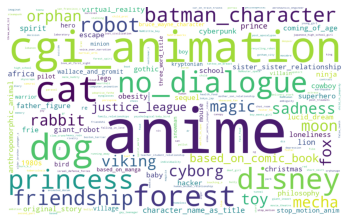

Nuage de mots pour le genre Comedy


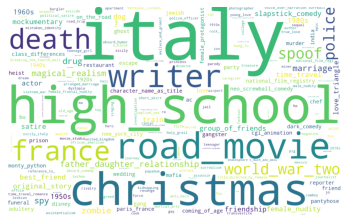

Nuage de mots pour le genre Family


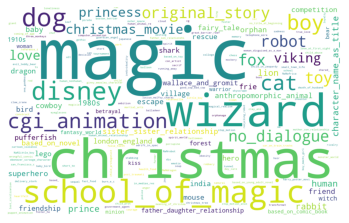

Nuage de mots pour le genre Adventure


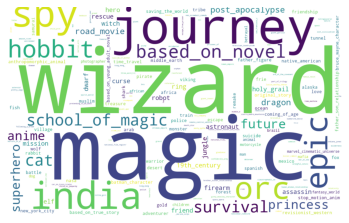

Nuage de mots pour le genre Fantasy


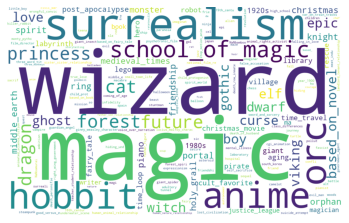

Nuage de mots pour le genre Romance


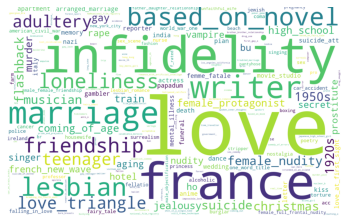

Nuage de mots pour le genre Drama


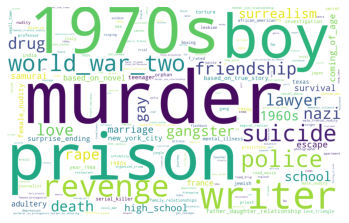

Nuage de mots pour le genre Action


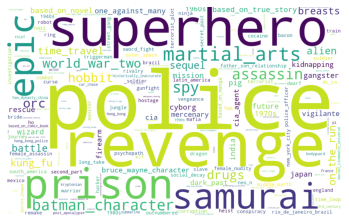

Nuage de mots pour le genre Crime


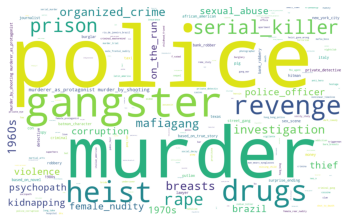

Nuage de mots pour le genre Thriller


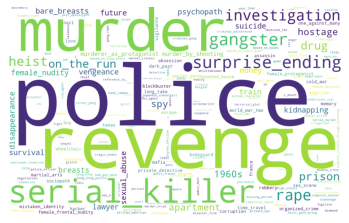

Nuage de mots pour le genre Horror


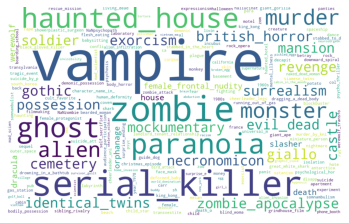

Nuage de mots pour le genre History


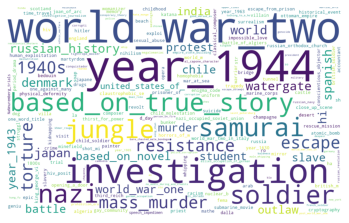

Nuage de mots pour le genre Science


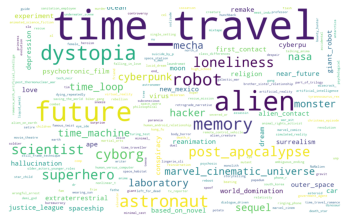

Nuage de mots pour le genre War


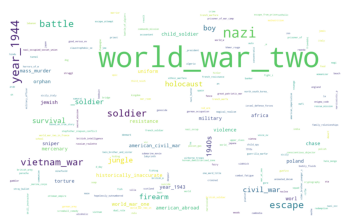

Nuage de mots pour le genre Mystery


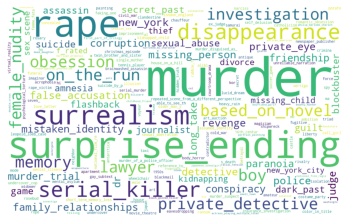

Nuage de mots pour le genre Music


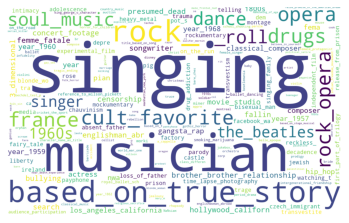

Nuage de mots pour le genre Documentary


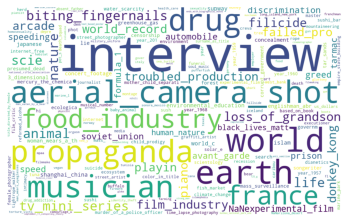

Nuage de mots pour le genre Western


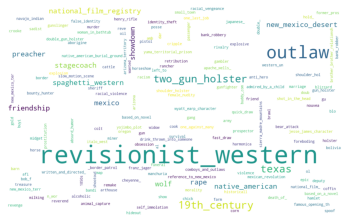

Nuage de mots pour le genre TV


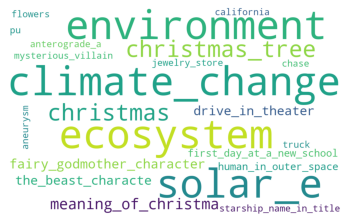

In [ ]:
for key in dico_nuages:
  if str(key) != 'Foreign':
    print('Nuage de mots pour le genre', key)
    nuage_de_mots(dico_nuages[str(key)])

Grâce à ces différents nuages de mots, nous pouvons déterminer quels mots-clés ressortent le plus dans les différents genres de films. Le résultat est assez cohérent. Néanmoins, pour les genres "Guerre" et "Western", les nuages de mots sont assez difficiles à lire dans la mesure où il y a très peu de mots-clés qui comportent beaucoup d'occurrences.

## Score et mots clés 

On considère comme "meilleurs films" les 200 meilleurs films de chacun des 3 types de scores utilisés : on pourra choisir comme le meilleur score celui qui donne un nuage de mots plus homogène.

In [66]:
def nuage_de_mots_par_score(score):
    liste_film = df.sort_values(by=score, ascending=False)['original_title'].head(200).tolist()
    mots_cles = ''
    for i in trange(len(liste_film)):
        for movie in df_2.title :
            if str(liste_film[i]) in str(movie) :
                mots_cles = mots_cles + str(df_2.keywords[i])
    return nuage_de_mots(mots_cles), mots_cles
    

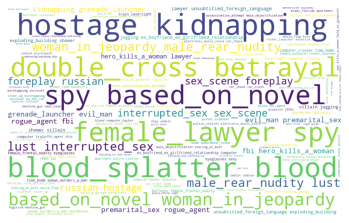

(None,
 '  toy rivalry cowboy cgi_animation claw_crane enemies_become_friends toy_comes_to_life piggy_bank computer_animation dog arcade_game two_word_title birthday child s_birthday scene_during_opening_credits 1990s dinosaur suburb child s_birthday_party birthday_present family_relationships jealousy action_figure birthday_party anthropomorphism brat threat magic_8_ball directorial_debut toy_dinosaur falling_out_a_window toy_soldier first_part spaceman_toy friend mr_potato_head wilhelm_scream slinky_dog blockbuster single_mother surprise_ending bo_peep_character buzz_lightyear_character woody_character poster wallpaper thunderstorm talking_toy toy_animal gift squeeze_toy bedroom computer_generated_imagery boy toy_story anthropomorphic_toy child s_bedroom scene_before_opening_credits character s_point_of_view_camera_shot famous_line first_of_series astronaut cowboy_doll dog_as_gift pet_as_gift mother_son_relationship reference_to_marie_antoinette commercial christmas_present toy_dog b

In [54]:
nuage_de_mots_par_score('popularity')

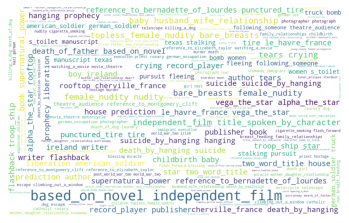

In [50]:
nuage_de_mots_par_score('score_1')

In [27]:
df_score = pd.merge(df_2, df, how='inner', on='imdb_id').sort_values(by='score_1', ascending=False).head(700)
#pd.merge(left, right, how='inner', on=None, left_on=None, right_on=None,
#        left_index=False, right_index=False, sort=True,
#        suffixes=('_x', '_y'), copy=True, indicator=False,
#        validate=None)
df_score = df_score.fillna('')

In [26]:
df_pop = pd.merge(df_2, df, how='inner', on='imdb_id').sort_values(by='popularity', ascending=False).head(700)
df_pop = df_pop.fillna('')

La LDA ou Latent Dirichlet Application/Allocation est une méthode de NLP qui va nous permettre de visualiser dans l'espace les mots clés.

On crée la fonction qui va nous faire la LDA. On va essayer de comparer selon les scores les topics retenus. 

In [ ]:
!pip install pyldavis

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


def LDA_on_dataset(series, n_topic):
  tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=1000)
  tfidf = tfidf_vectorizer.fit_transform(series)

  lda = LatentDirichletAllocation(n_components=n_topic, max_iter=5,
                                  learning_method='online',
                                  learning_offset=50.,
                                  random_state=0)
  lda.fit(tfidf)
  LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=n_topic, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)
  
  tf_feature_names = tfidf_vectorizer.get_feature_names()

  return pyLDAvis.sklearn.prepare(lda, tfidf, tfidf_vectorizer)
  


In [28]:

print('Score : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_score['keywords'], 10)

Score : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.035915 -0.000010       1        1  92.325180
5     -0.005791  0.000881       2        1   0.852778
9     -0.000970 -0.001274       3        1   0.852763
6      0.001294 -0.000327       4        1   0.852759
3      0.005325  0.000196       5        1   0.852755
1      0.005715  0.000317       6        1   0.852754
7      0.006706  0.000173       7        1   0.852753
8      0.007477  0.000271       8        1   0.852753
0      0.007158  0.000048       9        1   0.852753
4      0.009001 -0.000274      10        1   0.852752, topic_info=          Term       Freq      Total Category  logprob  loglift
891        the  70.000000  70.000000  Default  30.0000  30.0000
909         to  61.000000  61.000000  Default  29.0000  29.0000
170  character  47.000000  47.000000  Default  28.0000  28.0000
627         of  49.000000  49.000000  Default  27.0000  27.0000
719  reference  47.000000  47.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
888  terrorist   0.072177   7.460017  Topic10  -6.7637   0.1263
783       ship   0.072520  10.429990  Topic10  -6.7590  -0.2041
674     police   0.074501  30.711580  Topic10  -6.7320  -1.2571
810      snake   0.070962   5.598473  Topic10  -6.7807   0.3964
325     father   0.070894  21.161892  Topic10  -6.7816  -0.9343

[757 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.919137    1980s
3         1  0.807609    2010s
7         1  0.858132    abuse
10        1  0.982052   action
14        1  0.969178   aerial
...     ...       ...      ...
988       1  0.991701    woman
991       1  0.928903    world
993       1  0.972518  writing
996       1  0.957414     york
999       1  0.851419   zombie

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 10, 7, 4, 2, 8, 9, 1, 5])

In [29]:
print('Popularity : \n')
pyLDAvis.enable_notebook()
LDA_on_dataset(df_pop['keywords'], 10)

Popularity : 



PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.040683 -0.000002       1        1  91.819464
3      0.002665  0.000390       2        1   0.908959
4     -0.003412 -0.000133       3        1   0.908949
9     -0.003558 -0.000738       4        1   0.908948
8     -0.004911  0.000219       5        1   0.908948
0     -0.004459 -0.000438       6        1   0.908948
5     -0.006210 -0.000165       7        1   0.908947
7     -0.007045  0.000310       8        1   0.908946
6     -0.006752  0.000516       9        1   0.908946
1     -0.007001  0.000041      10        1   0.908946, topic_info=          Term       Freq      Total Category  logprob  loglift
459         in  71.000000  71.000000  Default  30.0000  30.0000
885        the  62.000000  62.000000  Default  29.0000  29.0000
903         to  60.000000  60.000000  Default  28.0000  28.0000
621         of  48.000000  48.000000  Default  27.0000  27.0000
169  character  43.000000  43.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
627         on   0.074203  29.702378  Topic10  -6.7333  -1.2915
392       good   0.071653   7.557487  Topic10  -6.7683   0.0422
271       drug   0.071692   8.583514  Topic10  -6.7677  -0.0846
459         in   0.072615  71.464220  Topic10  -6.7549  -2.1911
621         of   0.072403  48.425320  Topic10  -6.7579  -1.8049

[756 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.800470       1990s
2         1  0.847450       2010s
3         1  0.969077          47
7         1  0.901177      accent
9         1  0.874422  accusation
...     ...       ...         ...
986       1  0.934778       woods
987       1  0.949361        word
991       1  0.862655  wristwatch
996       1  0.986506        york
999       1  0.860248      zombie

[375 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 5, 10, 9, 1, 6, 8, 7, 2])

# Statistiques sur le résumé

In [100]:
df.overview.head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [101]:
df.overview = df.overview.fillna('')

On va retirer les stopwords dans les résumés. 

In [46]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [102]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop.extend(['mr', 'it', 'ex', 'in', 'he', 'and', 'there', 'however', 'to', 'now', 'to', 'of', 'the', 'they', 'but', 'soon', 'film', 'that', 'who', 'of'])


df["overview"] = df["overview"].str.lower().str.split()

df['overview'] = df['overview'].apply(lambda x: [item for item in x if item not in stop])


In [103]:
df.overview.head()

0    [led, woody,, andy's, toys, live, happily, roo...
1    [siblings, judy, peter, discover, enchanted, b...
2    [family, wedding, reignites, ancient, feud, ne...
3    [cheated, on,, mistreated, stepped, on,, women...
4    [george, banks, recovered, daughter's, wedding...
Name: overview, dtype: object

In [104]:
for i in trange(len(df.overview)) : 
  str1 = ','.join(df.overview[i])
  df.overview[i]= str1 
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [105]:
df.overview.head()

0    led,woody,,andy's,toys,live,happily,room,andy'...
1    siblings,judy,peter,discover,enchanted,board,g...
2    family,wedding,reignites,ancient,feud,next-doo...
3    cheated,on,,mistreated,stepped,on,,women,holdi...
4    george,banks,recovered,daughter's,wedding,,rec...
Name: overview, dtype: object

## Détermination des mots fréquemment utilisés dans les meilleurs films

 Par LDA (*Latent Dirichlet Allocation*)

In [106]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df['overview'], 10)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.044674  0.113111       1        1  22.396284
2      0.004096  0.111736       2        1  14.522269
8     -0.092982  0.125743       3        1  13.700588
7      0.046099  0.126912       4        1  11.086190
9      0.116662 -0.015722       5        1   8.578357
5     -0.045069  0.027051       6        1   7.204302
6     -0.151186  0.021994       7        1   7.164822
1      0.069021 -0.101322       8        1   5.797483
4      0.269977 -0.175614       9        1   4.977005
0     -0.261294 -0.233890      10        1   4.572701, topic_info=           Term        Freq       Total Category  logprob  loglift
958         war  559.000000  559.000000  Default  30.0000  30.0000
471      killer  325.000000  325.000000  Default  29.0000  29.0000
670      police  407.000000  407.000000  Default  28.0000  28.0000
590      murder  410.000000  410.000000  Default  27.0000  27.0000
671   political  236.000000  236.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
375  government   96.806802  192.339023  Topic10  -4.2927   2.3985
38     american  162.080456  432.669807  Topic10  -3.7773   2.1032
180     country   88.147566  277.192187  Topic10  -4.3864   1.9394
463     journey   84.224145  293.772312  Topic10  -4.4319   1.8357
94        black   72.972388  231.212544  Topic10  -4.5753   1.9318

[511 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
3         2  0.714582         20
3         4  0.200584         20
3         7  0.075219         20
4         2  0.192027  abandoned
4         3  0.050094  abandoned
...     ...       ...        ...
997       6  0.034230      young
997       7  0.054366      young
997       8  0.068461      young
997       9  0.045305      young
997      10  0.009061      young

[1837 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 9, 8, 10, 6, 7, 2, 5, 1])

On peut comparer avec la LDA faite sur les mots-cles. 

In [234]:
df_score['keywords']=df_score.keywords.apply(lambda x: [item for item in x if item not in stop])


In [229]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df_score['keywords'], 10)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.035915 -0.000010       1        1  92.325180
5     -0.005791  0.000881       2        1   0.852778
9     -0.000970 -0.001274       3        1   0.852763
6      0.001294 -0.000327       4        1   0.852759
3      0.005325  0.000196       5        1   0.852755
1      0.005715  0.000317       6        1   0.852754
7      0.006706  0.000173       7        1   0.852753
8      0.007477  0.000271       8        1   0.852753
0      0.007158  0.000048       9        1   0.852753
4      0.009001 -0.000274      10        1   0.852752, topic_info=          Term       Freq      Total Category  logprob  loglift
891        the  70.000000  70.000000  Default  30.0000  30.0000
909         to  61.000000  61.000000  Default  29.0000  29.0000
170  character  47.000000  47.000000  Default  28.0000  28.0000
627         of  49.000000  49.000000  Default  27.0000  27.0000
719  reference  47.000000  47.000000  Default  26.0000  26.0000
..         ...        ...        ...      ...      ...      ...
888  terrorist   0.072177   7.460017  Topic10  -6.7637   0.1263
783       ship   0.072520  10.429990  Topic10  -6.7590  -0.2041
674     police   0.074501  30.711580  Topic10  -6.7320  -1.2571
810      snake   0.070962   5.598473  Topic10  -6.7807   0.3964
325     father   0.070894  21.161892  Topic10  -6.7816  -0.9343

[757 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.919137    1980s
3         1  0.807609    2010s
7         1  0.858132    abuse
10        1  0.982052   action
14        1  0.969178   aerial
...     ...       ...      ...
988       1  0.991701    woman
991       1  0.928903    world
993       1  0.972518  writing
996       1  0.957414     york
999       1  0.851419   zombie

[372 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 10, 7, 4, 2, 8, 9, 1, 5])

# Statistiques sur les tags

In [42]:
df.tagline = df.tagline.fillna(' ')

0                                                         
1                Roll the dice and unleash the excitement!
2        Still Yelling. Still Fighting. Still Ready for...
3        Friends are the people who let you be yourself...
4        Just When His World Is Back To Normal... He's ...
                               ...                        
45461           Rising and falling between a man and woman
45462                                                     
45463                               A deadly game of wits.
45464                                                     
45465                                                     
Name: tagline, Length: 45466, dtype: object

In [86]:
stop = stopwords.words('english')
df.tagline = df.tagline.fillna('')

df["tagline"] = df["tagline"].str.lower().str.split()
df['tagline']=df.tagline.apply(lambda x: [item for item in x if item not in stop])

df.tagline.head()


0                                                   []
1                   [roll, dice, unleash, excitement!]
2    [still, yelling., still, fighting., still, rea...
3    [friends, people, let, yourself..., never, let...
4      [world, back, normal..., he's, surprise, life!]
Name: tagline, dtype: object

In [87]:

for i in trange(len(df.tagline)) : 
  str1 = ','.join(df.tagline[i])
  df.tagline[i]= str1 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [88]:
df.tagline.head()

0                                                     
1                        roll,dice,unleash,excitement!
2     still,yelling.,still,fighting.,still,ready,love.
3    friends,people,let,yourself...,never,let,forge...
4             world,back,normal...,he's,surprise,life!
Name: tagline, dtype: object

In [90]:
pyLDAvis.enable_notebook()
LDA_on_dataset(df['tagline'], 10)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.141998 -0.105948       1        1  11.315622
9      0.165265  0.069923       2        1  10.891165
8      0.222872 -0.234068       3        1  10.824395
3     -0.168232 -0.026078       4        1  10.368210
6     -0.240358 -0.056853       5        1  10.006380
5     -0.013799  0.084889       6        1   9.817386
2     -0.114894  0.018449       7        1   9.591591
1      0.076257  0.091443       8        1   9.579322
0      0.079180  0.312095       9        1   8.921231
7      0.135708 -0.153853      10        1   8.684697, topic_info=          Term        Freq       Total Category  logprob  loglift
819      story  365.000000  365.000000  Default  30.0000  30.0000
49        back  177.000000  177.000000  Default  29.0000  29.0000
599        new  205.000000  205.000000  Default  28.0000  28.0000
150     comedy  157.000000  157.000000  Default  27.0000  27.0000
878       time  228.000000  228.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
874   thriller   30.175881   31.235856  Topic10  -4.5987   2.4091
988      worst   29.964831   31.024845  Topic10  -4.6057   2.4088
818    stories   29.828125   30.888124  Topic10  -4.6103   2.4087
787  sometimes   70.657434   90.020811  Topic10  -3.7479   2.2014
491       life   44.449495  320.698794  Topic10  -4.2114   0.4675

[386 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         2  0.979044        000
10        1  0.978321     action
12        6  0.993911  adventure
16        9  0.982563      again
17        8  0.978814        age
...     ...       ...        ...
992      10  0.982639       year
993       5  0.989646      years
996       2  0.282040        you
996       6  0.717187        you
997       2  0.979378      young

[409 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 9, 4, 7, 6, 3, 2, 1, 8])